## Pointcloud.py

This is demo of small python package for working with point clouds. IT was developed for faster and easyier researching and prototypeing new neural networks for point cloud classifcation.

Features:
* support of multi tile pointclouds
* sub-sampling
* statistics
* tiling
* saving
* generating train / test split


In [1]:
%matplotlib notebook
import sys, os
from pointcloud.project import Project
import pointcloud.utils as pcutils
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

First we have to define workspace where point files are stored. We also set some names.

In [2]:
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
workspace = './data/tiles_10/'
project_name = 'tiles_10'
min_num_of_points = 1024
point_cloud_name = 'tiles_10'

labels = {
    "0": {
        "code": "1",
        "name": "low",
        "color": "#3281ff",
    },
    "1": {
        "code": "1",
        "name": "ground",
        "color": "#f9ac1b",
    },
    "2": {
        "code": "2",
        "name": "vegetation",
        "color": "#00ad1a",
    },
    "3": {
        "code": "3",
        "name": "building",
        "color": "#c40330",
    },
    "4": {
        "code": "4",
        "name": "powerline",
        "color": "#f9f509",
    },
    "5": {
        "code": "5",
        "name": "tower",
        "color": "#f702de",
    },
    "6": {
        "code": "6",
        "name": "other",
        "color": "#f9f509",
    }
}


We dan generate new project from above settings. In project class are all meta data needed. Project can has many pointclouds and each point cloud can be tiled. If we have large project of whole counties data can not be stored in single file. There for it is tiled. When we are adding new pointcloud it can be from single or multi tiles. For each tile we have to calculate bounding box. 

We have two options for bounding box calculation:
* Calculation from file name (lot of times tile grid is regular sized grid. Coordinates of one corner are usually specified in filename. There for we can reconstruct bounding box from X, Y and grid size) - fast
* Calculation of convex hull around points - slow

We can save project and later loaded it so this calculation does not need to be done every time.

In [3]:
project = Project(project_name, workspace=workspace, epsg=3912)
if  project.can_load():
    project.load()
else:
    print('Creating project from tiles in workspace')
    pointcloud = project.add_new_pointcloud(point_cloud_name)
    print('Processing Polygons')
    names_polygons = pcutils.misc.get_names_and_polygons_in_workspace(workspace)
    
    for i, data in enumerate(names_polygons):
        sys.stdout.write('\r {0}/{1}'.format(i + 1, len(names_polygons)))
        sys.stdout.flush()
    
        sys.stdout.write('\r Adding tiles {0}/{1}'.format(i + 1, len(names_polygons)))
        sys.stdout.flush()
        pointcloud.add_tile(data['name'], data['polygon'])

project.save()


Loading project tiles_10

Saving project tiles_10


For each project we can generate basic statistics

In [5]:
stats = project.get_stats()
print('Project name: {0}'.format(stats['name']))
print('Workspace: {0}'.format(stats['workspace']))
print('Number of point clouds: {0}'.format(stats['num_pointclouds']))

for key, pointcloud in stats['pointclouds'].items():
    print('\n-----  PointCloud {0} -----'.format(key))
    print('Area: {:6.2f} km2'.format(pointcloud['area'] / 1000000))
    print('Number of points: {0} ({1:4.2f} M)'.format(pointcloud['num_points'], pointcloud['num_points']/1000000))
    print('Density: {0} pts/m2'.format(pointcloud['density']))
    print('Number of tiles: {0}'.format(pointcloud['tiles']))
    
project.save()

Project name: tiles_10
Workspace: /home/flycom/data/tb4/data/kelag/2017/tiles_10/
Number of point clouds: 1

-----  PointCloud tiles_10 -----
Area:   4.59 km2
Number of points: 352926380 (352.93 M)
Density: 76.87 pts/m2
Number of tiles: 51731

Saving project tiles_10


When project is loaded we can get point cloud by the name and same is true for the tiles. 

In [4]:
cloud = project.get_point_cloud('tiles_10')
tile_names = cloud.get_tiles()
tile = cloud.get_tile(list(tile_names.keys())[0])
points = tile.get_points()

In [7]:
print(labels[str(0)]['color'])

#c5d9f9


In [163]:
tile_names = cloud.get_tiles()

wrong_tiles=[]
for i, tile_name in enumerate(tile_names):
    tile = cloud.get_tile(tile_name)
    points = tile.get_points()
    sys.stdout.write('\r {0}/{1}'.format(i + 1, len(tile_names)))
    sys.stdout.flush()
    if np.any(points[:,-1] == 8):
        wrong_tiles.append(tile_name)

    
    



 51731/51731

82


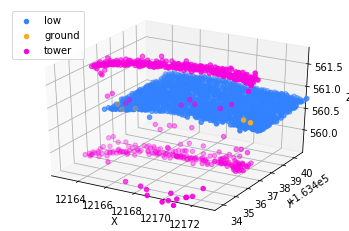

In [180]:
print(len(wrong_tiles))
tile = cloud.get_tile(wrong_tiles[59])
points = tile.get_points()

# points = points[points[:,-1] < 10]
def reduce_class(points):
    p = points[:,:3]
    c = np.expand_dims(points[:,-1], -1)
    c -= 1
    return np.concatenate((p, c), axis=1)

points = reduce_class(points)
pcutils.misc.plot_3d(points, max_points=2000, labels=labels)       


# 27 -> 1 
# TODO Maybe filter out low points
# 10 -> ground

In [178]:
## Replace wrong classifications
def replace_class(points, source_class, target_class):
    p = points[:,:3]
    c = np.expand_dims(points[:,-1], -1)
    c[c == source_class] = target_class

    return np.concatenate((p, c), axis=1)

 82/82

In [6]:
project.reset_stats()
stats = project.get_stats()

In [7]:
print(stats)

{'name': 'tiles_10', 'num_pointclouds': 1, 'workspace': '/home/flycom/data/tb4/data/kelag/2017/tiles_10/', 'pointclouds': {'tiles_10': {'area': 4590927.460000096, 'num_points': 352926380, 'density': 76.87, 'tiles': 51731}}}


In [5]:
cloud.reset_stats()
cloud_stats = cloud.get_stats()
print(cloud_stats)

{'area': 4590927.460000096, 'num_points': 352926380, 'density': 76.87, 'tiles': 51731, 'class_frequency': {1: 179466658, 2: 165816421, 4: 2214415, 6: 1259845, 0: 2402, 5: 562931, 3: 3603708}}


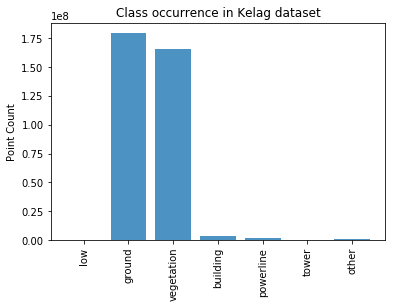

In [24]:
 
labels_plot = []
freq = []
for classification, details in labels.items():
#     labels_plot.append('ba')
    labels_plot.append(details['name'])
    freq.append(cloud_stats['class_frequency'][int(classification)])
y_pos = np.arange(len(labels_plot))

plt.bar(y_pos, freq, align='center', alpha=0.8)
plt.xticks(y_pos, labels_plot, rotation='vertical')
plt.ylabel('Point Count')
plt.title('Class occurrence in dataset')
 
plt.show()

In [12]:
cloud_stats['class_frequency'][0]

2402

In [28]:
class_counts = np.array(freq)
class_weights = (1 / np.log(1.2 + class_counts))
print(class_weights)

[0.12845947 0.05261635 0.05283627 0.06623624 0.06844393 0.07552348
 0.07119211]


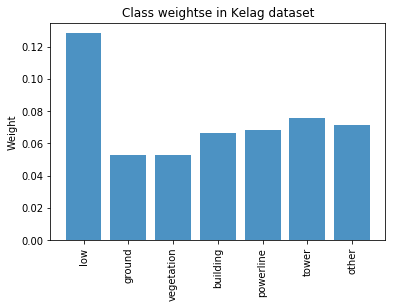

In [29]:
labels_plot = []
freq = []
for classification, details in labels.items():
#     labels_plot.append('ba')
    labels_plot.append(details['name'])
    freq.append(cloud_stats['class_frequency'][int(classification)])
y_pos = np.arange(len(labels_plot))

plt.bar(y_pos, class_weights, align='center', alpha=0.8)
plt.xticks(y_pos, labels_plot, rotation='vertical')
plt.ylabel('Weight')
plt.title('Class weights in dataset')
 
plt.show()